In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import random
import time
import csv
from datetime import datetime
import pytz
tz = pytz.timezone('Europe/Berlin')
import seaborn as sns

In [2]:
x = np.asarray([1, 2, 1, 2, 1.5])
y = np.asarray([1, 1, 2, 2, 1.5])
z = np.asarray([10, 15, -2, 2, 0])

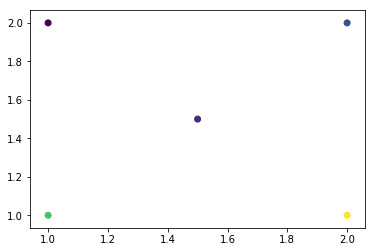

In [3]:
plt.scatter(x,y,c=z)

In [4]:
def intake_2Dlinter(xdata, ydata, zdata, gridrez):
    X,Y = np.meshgrid(np.linspace(min(x), max(x), endpoint=True, num=gridrez), np.linspace(min(y), max(y), endpoint=True, num=gridrez))  
    A = np.c_[xdata, ydata, np.ones(len(zdata))]
    C,_,_,_ = scipy.linalg.lstsq(A, zdata)
    Z = C[0]*X + C[1]*Y + C[2]
    return Z

In [5]:
gridrez = 10
XX,YY = np.meshgrid(np.linspace(min(x), max(x), endpoint=True, num=gridrez), np.linspace(min(y), max(y), endpoint=True, num=gridrez))

ZZ = intake_2Dlinter(x,y,z,gridrez)

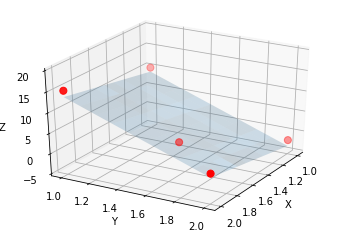

In [6]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1, alpha=0.2)
ax.scatter(x, y, z, c='r', s=50)
plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('Z')
ax.axis('equal')
ax.axis('tight')
ax.set_zlim(-5,20)
ax.view_init(30, 30)
plt.show()

In [7]:
def create_ranges(start, stop, N, endpoint=True):
    if endpoint==1:
        divisor = N-1
    else:
        divisor = N
    steps = (1.0/divisor) * (stop - start)
    return steps[:,None]*np.arange(N) + start[:,None]

def linspace_nd(x,y,gridrez):
    a1 = create_ranges(x.min(axis=1), x.max(axis=1), N=gridrez, endpoint=True)
    a2 = create_ranges(y.min(axis=1), y.max(axis=1), N=gridrez, endpoint=True)
    out_shp = a1.shape + (a2.shape[1],)
    Xout = np.broadcast_to(a1[:,None,:], out_shp)
    Yout = np.broadcast_to(a2[:,:,None], out_shp)
    return Xout, Yout

def stacked_lstsq(L, b, rcond=1e-10):
    """
    Solve L x = b, via SVD least squares cutting of small singular values
    L is an array of shape (..., M, N) and b of shape (..., M).
    Returns x of shape (..., N)
    """
    u, s, v = np.linalg.svd(L, full_matrices=False)
    s_max = s.max(axis=-1, keepdims=True)
    s_min = rcond*s_max
    inv_s = np.zeros_like(s)
    inv_s[s >= s_min] = 1/s[s>=s_min]
    x = np.einsum('...ji,...j->...i', v,
                  inv_s * np.einsum('...ji,...j->...i', u, b.conj()))
    return np.conj(x, x)

def vectorized_bi2Dlinter(x_vals, y_vals, z_vals, gridrez):

    X,Y = linspace_nd(x_vals, y_vals, gridrez)
    A = np.stack((x_vals,y_vals,np.ones_like(z_vals)), axis=2)
    C = stacked_lstsq(A, z_vals)
    n_bcast = C.shape[0]
    return C.T[0].reshape((n_bcast,1,1))*X + C.T[1].reshape((n_bcast,1,1))*Y + C.T[2].reshape((n_bcast,1,1))

In [ ]:
results =  []

for i in range(5):
    for jj in range(100):
        laenge = 10**i

        x1loc = 1.0
        x2loc = 2.0
        x3loc = 1.0
        x4loc = 2.0
        x5loc = 1.5

        y1loc = 1.0
        y2loc = 1.0
        y3loc = 2.0
        y4loc = 2.0
        y5loc = 1.5
        
        
        xxx = x1loc+np.random.rand(laenge)
        
        df2 = pd.DataFrame({"x1":xxx,
                            "x2":x2loc+np.random.rand(laenge),
                            "x3":x3loc+np.random.rand(laenge),
                            "x4":x4loc+np.random.rand(laenge),
                            "x5":x5loc+np.random.rand(laenge),
                            "y1":y1loc+np.random.rand(laenge),
                            "y2":y2loc+np.random.rand(laenge),
                            "y3":y3loc+np.random.rand(laenge),
                            "y4":y4loc+np.random.rand(laenge),
                            "y5":y5loc+np.random.rand(laenge),
                            "z1":np.random.rand(laenge),
                            "z2":np.random.rand(laenge),
                            "z3":np.random.rand(laenge),
                            "z4":np.random.rand(laenge),
                            "z5":np.random.rand(laenge),
                           })

        ZZ = []

        start = time.time()
        for index, row in df2.iterrows():
            x=row['x1'], row['x2'], row['x3'], row['x4'], row['x5']
            y=row['y1'], row['y2'], row['y3'], row['y4'], row['y5']
            z=row['z1'], row['z2'], row['z3'], row['z4'], row['z5']
            ZZ.append(np.mean(intake_2Dlinter(x,y,z, gridrez)))
        df2['ZZl']=ZZ
        end = time.time()

        start2 = time.time()
        x_vals = df2[['x1','x2','x3','x4','x5']].values
        y_vals = df2[['y1','y2','y3','y4','y5']].values
        z_vals = df2[['z1','z2','z3','z4','z5']].values

        res = vectorized_bi2Dlinter(x_vals,y_vals,z_vals,gridrez)
        YY = np.mean(np.mean(res, axis=2),axis=1).tolist()
        df2['ZZv']=YY
        end2 = time.time()

        results.append([laenge, end-start, end2-start2, np.mean((df2['ZZv'].values- df2['ZZl'].values)/ df2['ZZl'].values)])

with open('results_'+(datetime.now(tz)).strftime("%Y%m%d-%H%M%S")+'.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerow(["dfRowCount", "initial", "vectorized", 'sol.lin', 'sol.vec'])
    writer.writerows(results)

csvFile.close()

In [ ]:
npresults = np.asarray(results)

postresults = []
for case in sorted(list(set(npresults[:,0]))):
    a = npresults[npresults[:,0]==case, 1].mean()
    b = npresults[npresults[:,0]==case, 2].mean()
    c = npresults[npresults[:,0]==case, 3].mean()
    postresults.append([case, a, b, c])
    
nppostresults = np.asarray(postresults)

In [ ]:
df = pd.DataFrame(npresults)
df.columns = ['NumberOfRows', 'iterate', 'vectorize', 'rel.dif']
df['NumberOfRows'] = np.int32(df['NumberOfRows'].values)
df['log.vectorize'] = np.log((df['vectorize'].values).astype('float'))
df['log.iterate']   = np.log((df['iterate'].values).astype('float'))

In [ ]:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(15)

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

ax1.plot(nppostresults[:,0],nppostresults[:,1]*1000, color='blue', marker='s', label="iterate", markerfacecolor='white', markeredgewidth=2, markeredgecolor='blue', markersize=7.5,  linewidth=2)
ax1.plot(nppostresults[:,0],nppostresults[:,2]*1000, color='red', marker='o', label="vectorized",    markerfacecolor='white', markeredgewidth=2, markeredgecolor='red', markersize=8,  linewidth=2)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Number of rows in Dataframe')
ax1.set_ylabel('Duration in ms')
ax1.legend()

ax2.plot(nppostresults[:,0], nppostresults[:,3], color='green', marker='v', label="rel. difference", markerfacecolor='white', markeredgewidth=2, markeredgecolor='green', markersize=7.5,  linewidth=2)
ax2.set_xscale('log')
#ax2.set_yscale('log')
ax2.set_xlabel('Number of rows in Dataframe')
ax2.set_ylabel('rel. difference in %')
ax2.legend()

df2 = pd.melt(df[['NumberOfRows','log.iterate','log.vectorize']], id_vars=['NumberOfRows'])
sns.swarmplot(x='NumberOfRows',y='value',hue='variable', data=df2, ax=ax3)
ax3.set(xlabel='Number of Rows in DataFrame', ylabel='LOG(duration)')
ax3.legend().set_title('')

df3 = pd.melt(df[['NumberOfRows','rel.dif']], id_vars=['NumberOfRows'])
sns.swarmplot(x='NumberOfRows',y='value', data=df3, ax=ax4)
ax4.set(xlabel='Number of Rows in DataFrame', ylabel='rel.difference in %')